In [1]:
import sys

In [2]:
!which python

/anaconda3/bin/python


In [3]:
sys.path.append("/Users/aaron/Documents/github/ssdmultibox/venv/lib/python3.6/site-packages/")

In [4]:
import enum
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import device, ValPascalDataset, Bboxer
from ssdmultibox.datasets.v2 import TrainPascalDataset
from ssdmultibox.models import SSDModel
from ssdmultibox.plotting import *

In [5]:
EPOCHS = 1
BATCH = 4
NUM_WORKERS = 0 # MAC: sysctl -n hw.ncpu
LR = 0.01

In [6]:
# item = next(iter(dataloaders[Phase.TRAIN]))
TrainPascalDataset

ssdmultibox.datasets.v2.TrainPascalDataset

In [7]:
dataset = TrainPascalDataset()

In [8]:
image_id, im, gt_bbs, gt_cats = dataset[1]
image_id, im.shape, gt_bbs.shape, gt_cats.shape

(17, (3, 300, 300), (2, 4), (2,))

In [9]:
gt_bbs

array([[ 50.27472527, 115.        , 163.01098901, 173.375     ],
       [ 63.46153846,  55.625     , 275.92307692, 250.875     ]])

In [10]:
ann = dataset.get_annotations()[image_id]
ann

{'image_path': '/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/000017.jpg',
 'bbs': [[184, 61, 95, 138], [89, 77, 314, 259]],
 'cats': [14, 12]}

In [11]:
pascal_bb = Bboxer.fastai_bb_to_pascal_bb(gt_bbs[0])
pascal_bb

array([115.        ,  50.27472527,  58.375     , 112.73626374])

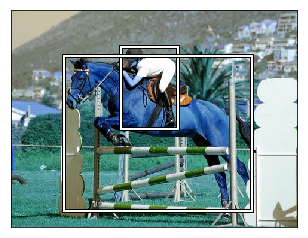

In [12]:
im = open_image(ann['image_path'])
ax = show_img(im)
draw_rect(ax, np.array(ann['bbs'][0]))
draw_rect(ax, np.array(ann['bbs'][1]))

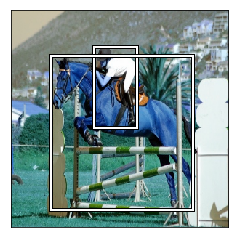

In [13]:
im = open_image(ann['image_path'])
im = cv2.resize(im, (SIZE, SIZE))
ax = show_img(im)
draw_rect(ax, Bboxer.fastai_bb_to_pascal_bb(gt_bbs[0]))
draw_rect(ax, Bboxer.fastai_bb_to_pascal_bb(gt_bbs[1]))

# PriorBox

In [14]:
anchors = Bboxer.anchor_corners(4)
anchors

array([[0.  , 0.  , 0.25, 0.25],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.5 , 0.25, 0.75],
       [0.  , 0.75, 0.25, 1.  ],
       [0.25, 0.  , 0.5 , 0.25],
       [0.25, 0.25, 0.5 , 0.5 ],
       [0.25, 0.5 , 0.5 , 0.75],
       [0.25, 0.75, 0.5 , 1.  ],
       [0.5 , 0.  , 0.75, 0.25],
       [0.5 , 0.25, 0.75, 0.5 ],
       [0.5 , 0.5 , 0.75, 0.75],
       [0.5 , 0.75, 0.75, 1.  ],
       [0.75, 0.  , 1.  , 0.25],
       [0.75, 0.25, 1.  , 0.5 ],
       [0.75, 0.5 , 1.  , 0.75],
       [0.75, 0.75, 1.  , 1.  ]])

In [15]:
anchors[:,:2], anchors[:,:2].shape

(array([[0.  , 0.  ],
        [0.  , 0.25],
        [0.  , 0.5 ],
        [0.  , 0.75],
        [0.25, 0.  ],
        [0.25, 0.25],
        [0.25, 0.5 ],
        [0.25, 0.75],
        [0.5 , 0.  ],
        [0.5 , 0.25],
        [0.5 , 0.5 ],
        [0.5 , 0.75],
        [0.75, 0.  ],
        [0.75, 0.25],
        [0.75, 0.5 ],
        [0.75, 0.75]]), (16, 2))

In [16]:
anchors.shape

(16, 4)

In [17]:
hw = np.repeat(.25, 32).reshape(16,2)
hw, hw.shape

(array([[0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25]]), (16, 2))

In [18]:
pascal_anchors = np.concatenate((anchors[:,:2], hw), axis=1)
pascal_anchors

array([[0.  , 0.  , 0.25, 0.25],
       [0.  , 0.25, 0.25, 0.25],
       [0.  , 0.5 , 0.25, 0.25],
       [0.  , 0.75, 0.25, 0.25],
       [0.25, 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.5 , 0.25, 0.25],
       [0.25, 0.75, 0.25, 0.25],
       [0.5 , 0.  , 0.25, 0.25],
       [0.5 , 0.25, 0.25, 0.25],
       [0.5 , 0.5 , 0.25, 0.25],
       [0.5 , 0.75, 0.25, 0.25],
       [0.75, 0.  , 0.25, 0.25],
       [0.75, 0.25, 0.25, 0.25],
       [0.75, 0.5 , 0.25, 0.25],
       [0.75, 0.75, 0.25, 0.25]])

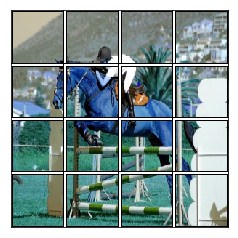

In [19]:
im = cv2.resize(im, (SIZE, SIZE))
ax = show_img(im)
for bb in pascal_anchors:
    draw_rect(ax, bb*SIZE)

using new `Bboxer.anchor_boxes` method

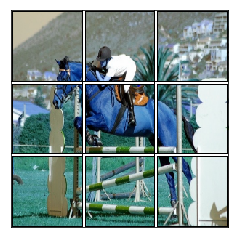

In [20]:
im = cv2.resize(im, (SIZE, SIZE))
ax = show_img(im)
for bb in Bboxer.anchor_boxes()[-2][0]:
    draw_rect(ax, bb*SIZE)